In [12]:
import controllers
import controlpy
import control_utils
import dynamics_models
import numpy as np
import polytope
import system_id
import tqdm
import uncertainty_utils
import experiment_utils
import trajectory_optimizers

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

In [13]:
# Dynamics Parameters
n_states = 4
n_inputs = 2
dt = 0.5
init_state = np.array([-3.5,0, np.pi/2, 0])
linearization_state = np.zeros(n_states)
linearization_input = np.zeros(n_inputs)

# State and Input Constraints
delta_lim = np.pi / 6
a_lim = 0.3
input_limits = polytope.box2poly([[-a_lim, a_lim], [-delta_lim, delta_lim]])
state_limits = polytope.box2poly([[-4,1],[-1,1],[-5 * np.pi, 5 *np.pi],[-0.1,1]])
state_constraints = (state_limits.A, state_limits.b)
input_constraints = (input_limits.A, input_limits.b)
input_bounds = (-np.array([a_lim, delta_lim]), np.array([a_lim, delta_lim]))

# Control Task
Q = np.diag([1, 10, 1, 1]) 
R = np.eye(n_inputs)
stage_cost = lambda x, u: x.T @ Q @ x + u.T @ R @ u

num_init_episodes = 1
init_input_noise_var = 1e-3
init_input_noise = init_input_noise_var * np.eye(n_inputs)
t_inp = uncertainty_utils.calc_t(0.95, n_inputs)
idb = t_inp * np.sqrt(init_input_noise_var)
input_noise_bound = polytope.box2poly([[-idb, idb]] * n_inputs)

# Noise and Disturbances
process_noise_var = 1e-5
process_noise = process_noise_var * np.eye(n_states)
t = uncertainty_utils.calc_t(0.95, n_states)
db = t * np.sqrt(process_noise_var)
disturbance_bound = polytope.box2poly([[-db, db]] * n_states)

# Experiment Details
episode_length = int(10 / dt)
controller_horizon = 5
state_reference = np.zeros(n_states)
input_reference = np.zeros(n_inputs)
num_episodes = 10



# System ID
h = 2
lamb = 1e-2
n_sysid_pts = 500
n_sysid_it = 10

# Save Results
save_dir = "dubin_car_expts_v2/"
save_data = False

# Vehicle
def get_vehicle():
    init_state_noisy = np.random.multivariate_normal(init_state, process_noise)
    vehicle = dynamics_models.DubinCar(init_state_noisy, dt, process_noise, use_ode_integrator=False)
    return vehicle

def sim_traj(vehicle, controller, input_limits, episode_length=episode_length, estimate_traj=None, get_linearizations=None, input_noise=None):
    x_traj = [vehicle.x]
    u_traj = []
    
    x_pred_trajs = []
    u_pred_trajs = []
    model_covs = []
    
    slacks = []
    terminal_slacks = []
    
    for _ in tqdm.tqdm(range(episode_length)):
        u_command = controller.solve(x_traj[-1]) if estimate_traj is None else controller.solve(x_traj[-1], get_linearizations, estimate_traj)
        if u_command is None:
            print("controller error at iteration %d" %_)
            print("state:")
            print(x_traj[-1])
            break
        if input_noise is not None: 
            u_noise = np.random.multivariate_normal(np.zeros(input_limits[0].shape), input_noise)
            u_command = u_command + u_noise
            
        u = np.minimum(np.maximum(input_limits[0], u_command), input_limits[1])
        x_next = vehicle.f(u)

        x_traj.append(x_next)
        u_traj.append(u)
        
        if hasattr(controller, "x_traj"):
            x_pred_trajs.append(controller.x_traj)
            u_pred_trajs.append(controller.u_traj)

            slacks.append(controller.slack.value)
            terminal_slacks.append(controller.terminal_slack.value)
        
    return np.array(x_traj), np.array(u_traj), x_pred_trajs, u_pred_trajs, slacks, terminal_slacks, model_covs

## Plotting
l = 0.125
w = 0.075
figsize = (8,4)
state_lims_proj = state_limits.project([1,2])

def plot_experiment(traj_list, x_preds, ax, xlims=(-5,2), ylims=(-1.5, 1.5), lw=2, k=10,bbox=(0,0)):
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel("x in (m)")
    ax.set_ylabel("y in (m)")
    state_lims_proj.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)
    
    for x_traj in traj_list:
        ss = ax.plot(x_traj[0,:], x_traj[1,:], "r--", label="safe set")
      
    x_traj = traj_list[-1].T
    ts = ax.plot(x_traj[:,0], x_traj[:,1], "k", lw=lw, label="final trajectory")
    patches = [dynamics_models.plot_vehicle(x[:3], l, w, alpha=0.4) for x in np.rollaxis(x_traj[::k,:],0)]
    for patch in patches:
        ax.add_patch(patch)
    
      
    for pred in x_preds:
        ps = ax.plot(pred[:,0], pred[:,1], color="tab:blue", linestyle="--", alpha=1, label="predictions")
        
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = zip(*[(handles[i], labels[i]) for i in [0,-1,-2]])
    handles = list(handles)
    labels = list(labels)
    handles.append(ax.patches[0])
    labels.append("state constraints")
    ax.legend(handles, labels, bbox_to_anchor=bbox)

## Init Traj, LTI MPC

In [14]:
vehicle = dynamics_models.DubinCar(init_state, dt, process_noise*0)
A, B, C = vehicle.get_linearization(linearization_state, linearization_input, dt)
A[1,2] = 0.025
K = controlpy.synthesis.controller_lqr_discrete_time(A, B, Q, R)

init_state_limits = control_utils.pontryagin_difference(state_limits, disturbance_bound)
init_input_limits = control_utils.pontryagin_difference(input_limits, input_noise_bound)
init_state_constraints = (init_state_limits.A, init_state_limits.b)
init_input_constraints = (init_input_limits.A, init_input_limits.b)

controller = controllers.LTI_MPC_Tracker(A, B, C,
                                         controller_horizon, 
                                         Q, 3*R, state_reference, input_reference,
                                         init_state_constraints, init_input_constraints)
controller.build()

In [15]:
x_init_trajs = []
u_init_trajs = []
for _ in range(num_init_episodes):
    vehicle = dynamics_models.DubinCar(init_state, dt, process_noise*0)
    x_init_traj, u_init_traj, x_init_preds, u_init_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, input_noise=init_input_noise)
    x_init_trajs.append(x_init_traj)
    u_init_trajs.append(u_init_traj)
init_value_functions = [control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost) for x_traj, u_traj in zip(x_init_trajs, u_init_trajs)]

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.39it/s]


## SCP on True Model, ground truth

In [16]:
traj_opt = trajectory_optimizers.SCP_Traj_Opt(episode_length, Q, R, 
                                              state_reference, np.zeros(n_inputs), 
                                              state_constraints, input_constraints, 
                                              tolerance=1e-5, regularization=1e-1)
traj_opt.build()

In [17]:
for i in range(20):
    vehicle = dynamics_models.DubinCar(init_state, dt, process_noise*0)
    if i == 0:
        As, Bs, Cs = control_utils.linearize_around(vehicle, x_init_traj.T, u_init_traj.T, vehicle.dt)
        x_traj_opt, u_traj_opt, converged = traj_opt.solve_iteration(x_init_traj.T, u_init_traj.T, As, Bs)
    else:
        As, Bs, Cs = control_utils.linearize_around(vehicle, x_traj.T, u_traj.T, vehicle.dt)
        x_traj_opt, u_traj_opt, converged = traj_opt.solve_iteration(x_traj.T, u_traj.T, As, Bs)
    
    controller = traj_opt.get_controller()
    x_traj, u_traj, _, _, _, _, _ = sim_traj(vehicle, controller, input_bounds, episode_length=episode_length)
    if converged:
        break
print("converged in %d iterations" % traj_opt.i)

100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1542.59it/s]


converged in 7 iterations


In [18]:
true_solution_costs = [control_utils.compute_traj_cost(x_traj[:,:-1], u_traj, stage_cost)[0] for x_traj, u_traj in zip(traj_opt.traj_list, traj_opt.input_traj_list)]
true_opt = true_solution_costs[-1]

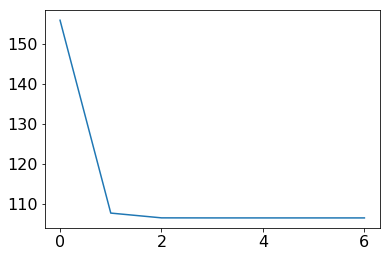

In [19]:
plt.plot(true_solution_costs)

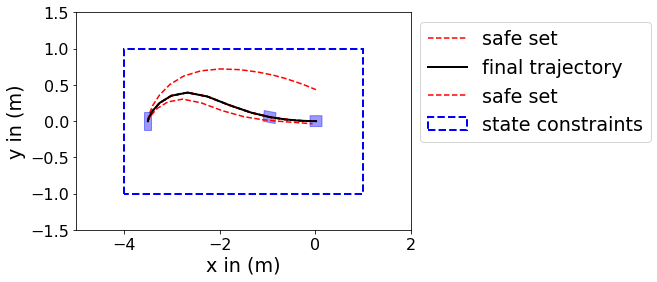

In [20]:
plt.figure()
ax = plt.gca()
plot_experiment(traj_opt.traj_list, [], ax, bbox=(1,1))

## SCP LMPC with Local Safe Sets

In [88]:
lin_vehicle = dynamics_models.DubinCar(init_state, dt, process_noise*0, use_ode_integrator=True)
def get_linearizations(x_traj, u_traj):
    return control_utils.linearize_around(lin_vehicle, x_traj, u_traj, dt)

def estimate_traj(x0, u_traj):
    vehicle = dynamics_models.DubinCar(x0, dt, process_noise*0)
    x_sim = [x0]
    for u in np.rollaxis(u_traj, 1):
        x = vehicle.f(u)
        x_sim.append(x)
    return np.array(x_sim).T, np.copy(u_traj)

In [93]:
lmpc_controllers = []
safe_set_size = 20
n_safe_set_it = 3
n_iters = [1]
for n_iter in n_iters:  
    controller = controllers.Local_SCP_LMPC(controller_horizon, Q, R, 
                                            state_reference, input_reference, 
                                            state_constraints, input_constraints, 
                                            n_safe_set_it, safe_set_size, 
                                            n_iter=n_iter, tolerance=1e-3, regularization=1e-20)
    controller.add_trajectory(x_init_traj.T[:,:-1], u_init_traj.T, init_value_functions[0])
    controller.build()
    slack_per_episode = []
    term_slack_per_episode = []
    for episode in range(num_episodes * 3):
        vehicle = dynamics_models.DubinCar(init_state, dt, process_noise*0)
    #     import pdb; pdb.set_trace()
        x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, model_covs = sim_traj(vehicle, controller, input_bounds, episode_length, estimate_traj=estimate_traj, get_linearizations=get_linearizations)
        value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)

        controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
        slack_per_episode.append(slacks)
        term_slack_per_episode.append(terminal_slacks)
        
    lmpc_controllers.append(controller)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.63it/s]


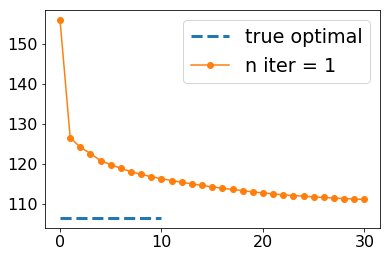

In [94]:
costs = [[q[0] for q in controller.value_func_list] for controller in lmpc_controllers]
plt.plot(np.arange(num_episodes + num_init_episodes), true_opt * np.ones(num_episodes + num_init_episodes), "--", lw=3)
for cost in costs[:]:
    plt.plot(cost, "-o")
plt.legend(["true optimal"] + ["n iter = %d" % n for n in n_iters])
# print(costs)

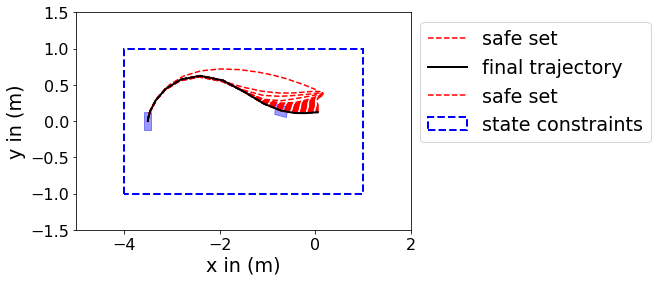

In [92]:
plt.figure()
ax = plt.gca()
plot_experiment(lmpc_controllers[0].traj_list, [], ax, bbox=(1,1))

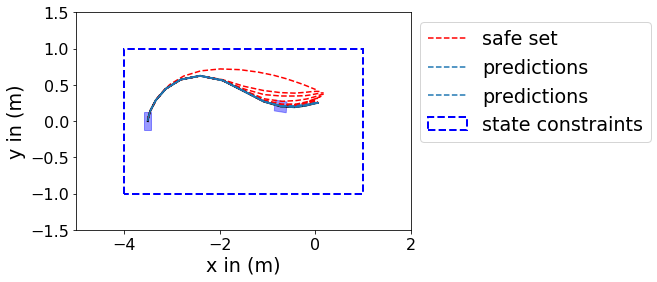

In [85]:
plt.figure()
ax = plt.gca()
plot_experiment(lmpc_controllers[-1].traj_list, [x.T for x in x_preds], ax, bbox=(1,1))

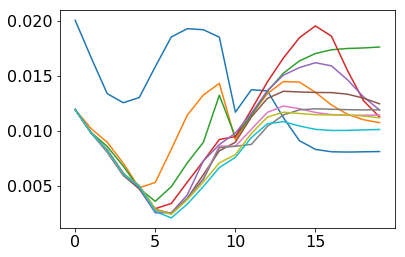

In [86]:
for tslack in term_slack_per_episode:
    plt.plot([np.linalg.norm(t) for t in tslack])

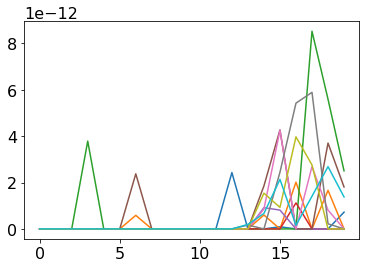

In [87]:
for slack in slack_per_episode:
    plt.plot([np.linalg.norm(s) for s in slack])

## Compare with local safe sets

In [73]:
safe_set_size = 20
n_safe_set_it = 3
controller = controllers.Local_LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, input_reference,
                                     state_constraints, input_constraints, n_safe_set_it, safe_set_size)
controller.build()
controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_functions[0])

In [74]:
def model_callback(vehicle, controller, episode_length):
    u_ss = controller.input_safe_set @ controller.multipliers.value
    input_traj = np.vstack((controller.u_traj[:,1:].value.T, u_ss)).T
    A, B, C = control_utils.linearize_around(vehicle, controller.x_traj[:,1:].value, input_traj, vehicle.dt)
    return A, B, C

In [75]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = dynamics_models.DubinCar(init_state, dt, process_noise*0)
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, multips = experiment_utils.sim_traj(vehicle, controller, input_bounds, episode_length, model_callback=model_callback)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    As, Bs, Cs = control_utils.linearize_around(vehicle, x_traj[:controller.N,:].T, u_traj[:controller.N,:].T, vehicle.dt)
    controller.set_models(As, Bs, Cs)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.57it/s]


In [76]:
local_mpc_costs = [q[0] for q in controller.value_func_list]

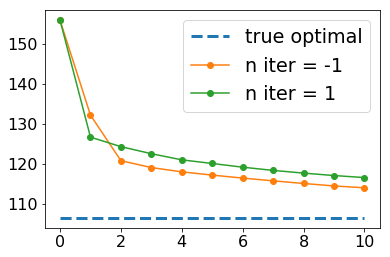

In [77]:
costs = [[q[0] for q in controller.value_func_list] for controller in lmpc_controllers]
plt.plot(np.arange(num_episodes + num_init_episodes), true_opt * np.ones(num_episodes + num_init_episodes), "--", lw=3)
n_iters_legend = [-1] + n_iters
plt.plot(local_mpc_costs, "-o")
for cost in costs[:]:
    plt.plot(cost, "-o")
plt.legend(["true optimal"] + ["n iter = %d" % n for n in n_iters_legend])
# plt.savefig("dubincarscplmpc.png")

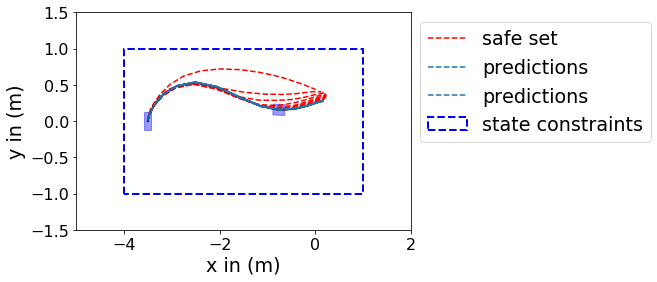

In [78]:
plt.figure()
ax = plt.gca()
plot_experiment(controller.traj_list, x_preds, ax, bbox=(1,1))

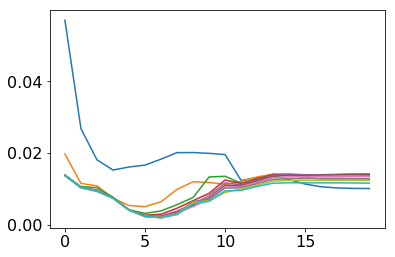

In [79]:
for tslack in term_slack_per_episode:
    plt.plot([np.linalg.norm(t) for t in tslack])


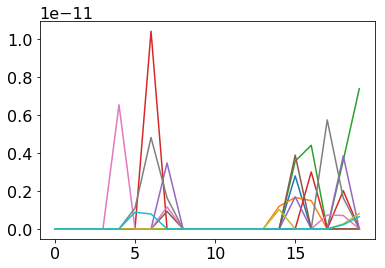

In [81]:
for slack in slack_per_episode:
    plt.plot([np.linalg.norm(s) for s in slack])

## Junk controller

In [66]:
safe_set_size = 20
n_safe_set_it = 3
controller = controllers.Local_LTV_LMPC(A, B, C,
                                     controller_horizon, 
                                     Q, R, state_reference, input_reference,
                                     state_constraints, input_constraints, n_safe_set_it, safe_set_size)
controller.build()
controller.add_trajectory(x_init_traj[:-1,:].T, u_init_traj.T, init_value_functions[0])

class JunkController:
    
    def __init__(self, vehicle, controller, n):
        self.controller = controller
        self.vehicle = vehicle
        self.n = n
        self.N = self.controller.N
        
    def solve(self, x0):
        for i in range(self.n):
            if self.controller.i is not 0:
                A, B, C = model_callback(self.vehicle, self.controller, episode_length)
                self.controller.set_models(A, B, C)
            u = self.controller.solve(x0)
            if i < self.n - 1:
                self.controller.x_ss = self.controller.x_traj[:,-1].value
        return u
    
    def add_trajectory(self, state_traj, input_traj, value_function):
        self.controller.add_trajectory(state_traj, input_traj, value_function)
        
junk_controller = JunkController(dynamics_models.DubinCar(init_state, dt, process_noise*0), controller, 3)

In [67]:
slack_per_episode = []
term_slack_per_episode = []
for episode in range(num_episodes):
    vehicle = dynamics_models.DubinCar(init_state, dt, process_noise*0)
    x_traj, u_traj, x_preds, u_preds, slacks, terminal_slacks, multips = experiment_utils.sim_traj(vehicle, junk_controller, input_bounds, episode_length)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, stage_cost)
    
    junk_controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)
    As, Bs, Cs = control_utils.linearize_around(vehicle, x_traj[:junk_controller.N,:].T, u_traj[:junk_controller.N,:].T, vehicle.dt)
    junk_controller.controller.set_models(As, Bs, Cs)
    slack_per_episode.append(slacks)
    term_slack_per_episode.append(terminal_slacks)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.96it/s]


In [68]:
junk_mpc_costs = [q[0] for q in junk_controller.controller.value_func_list]

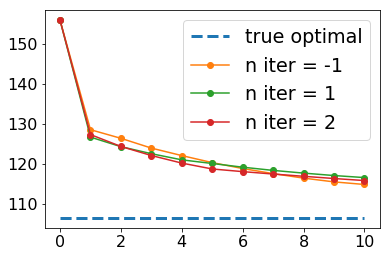

In [69]:
costs = [[q[0] for q in controller.value_func_list] for controller in lmpc_controllers]
plt.plot(np.arange(num_episodes + num_init_episodes), true_opt * np.ones(num_episodes + num_init_episodes), "--", lw=3)
n_iters_legend = [-1] + n_iters
plt.plot(junk_mpc_costs, "-o")
for cost in costs[:]:
    plt.plot(cost, "-o")
plt.legend(["true optimal"] + ["n iter = %d" % n for n in n_iters_legend])
# plt.savefig("dubincarscplmpc.png")